# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

ToDo:
- Find colored dataset to train on

In [1]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
image_size  = 28
autoencoder_depth = 10
dropout = 0.1
channels = 1

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], image_size, image_size, channels))
x_test = np.reshape(x_test, (x_test.shape[0], image_size, image_size, channels))
x_train.shape

(60000, 28, 28, 1)

## Variational Autoencoder

In [6]:
def EncoderBlock():
    def apply(x):
        x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
        return encoded
    
    return apply

def DecoderBlock():
    def apply(x):
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(16, (3, 3), activation='relu')(x)
        x = layers.UpSampling2D((2, 2))(x)
        decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
        return decoded
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(4, 4, 1))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
class VAE(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock()(input_image)
        z_mean = layers.Conv2D(1, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(1, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(4, 4, 1))
        decoded = DecoderBlock()(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [64]:
vae = VAE()
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=40, batch_size = 512)

Epoch 1/40
118/118 [==============================] - 2s 8ms/step - loss: 400.8289 - reconstruction_loss: 335.1245 - kl_loss: 1.9946
Epoch 2/40
118/118 [==============================] - 1s 8ms/step - loss: 232.0843 - reconstruction_loss: 210.9610 - kl_loss: 7.9448
Epoch 3/40
118/118 [==============================] - 1s 7ms/step - loss: 192.2553 - reconstruction_loss: 180.0022 - kl_loss: 7.9905
Epoch 4/40
118/118 [==============================] - 1s 7ms/step - loss: 178.1797 - reconstruction_loss: 168.2872 - kl_loss: 8.2982
Epoch 5/40
118/118 [==============================] - 1s 7ms/step - loss: 171.7286 - reconstruction_loss: 162.0688 - kl_loss: 8.6151
Epoch 6/40
118/118 [==============================] - 1s 8ms/step - loss: 166.3637 - reconstruction_loss: 156.6495 - kl_loss: 8.6494
Epoch 7/40
118/118 [==============================] - 1s 7ms/step - loss: 161.9994 - reconstruction_loss: 151.8575 - kl_loss: 8.7725
Epoch 8/40
118/118 [==============================] - 1s 7ms/step - l

In [9]:
batch_size = 512
encoded_images = vae.encode(x_train[0 : batch_size])

for i in range(1, int(x_train.shape[0] / batch_size)):
    encoded = vae.encode(x_train[i*batch_size : i * batch_size + batch_size])
    encoded_images = tf.concat([encoded_images, encoded], axis=0)

encoded_images.shape

TensorShape([59904, 4, 4, 1])

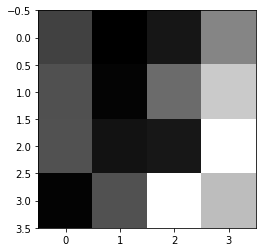

In [11]:
plt.imshow(encoded_images[0].numpy().reshape(4, 4), cmap='gray')

In [12]:
decoded_images = vae.decode(encoded_images[0 : batch_size])
batch_size = 512

for i in range(1, int(x_train.shape[0] / batch_size)):
    decoded = vae.decode(encoded_images[i*batch_size : i * batch_size + batch_size])
    decoded_images = tf.concat([decoded_images, decoded], axis=0)

decoded_images.shape

TensorShape([59904, 28, 28, 1])

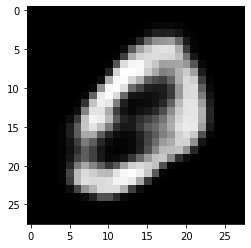

In [13]:
plt.imshow(decoded_images[1].numpy().reshape(28, 28), cmap='gray')

## Denoising U-Net

In [14]:
# Sampling.
min_signal_rate = 0.02
max_signal_rate = 0.95

# Architecture.
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

In [15]:
def diffusion_schedule(diffusion_times):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [16]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

In [17]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, (1, 1))(x)
            
        x = layers.Conv2D(width, (3, 3), padding='same', activation=keras.activations.swish)(x)
        x = layers.LayerNormalization()(x + residual)
        return x
    
    return apply

In [18]:
def DownBlock(width, block_depth):
    def apply(x):
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
        
    return apply

In [19]:
def UpBlock(width, block_depth):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation='bilinear')(x)
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
        return x
    
    return apply

In [42]:
def create_unet(widths, block_depth):
    noisy_images = keras.Input(shape=(4, 4, 1))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=4, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    for width in widths[:-1]:
        x = DownBlock(width, block_depth)(x)

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)(x)

    x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
    
    unet = keras.Model([noisy_images, noise_variances], x, name="residual_unet")
    unet.compile(optimizer='adam', loss='mean_absolute_error')
    return unet

In [43]:
def train(train_data, model, epochs, batch_size):
    steps_per_epoch = int(train_data.shape[0] / batch_size)
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = train_data[step * batch_size : step * batch_size + batch_size]
            noises = tf.random.normal(shape=(batch_size, 4, 4, 1))
            
            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
        
        print('Epoch ' + str(epoch) + ' completed.')

In [48]:
def reverse_diffusion(model, num_images, diffusion_steps):
    initial_noise = tf.random.normal(shape=(num_images, 4, 4, 1))
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2])
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [45]:
#unet = keras.models.load_model('../latent_diffusion_unet')
unet = create_unet([32, 64, 32], 4)

In [59]:
train(encoded_images, unet, 100, 2048)

Epoch 0 completed.
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.
Epoch 31 completed.
Epoch 32 completed.
Epoch 33 completed.
Epoch 34 completed.
Epoch 35 completed.
Epoch 36 completed.
Epoch 37 completed.
Epoch 38 completed.
Epoch 39 completed.
Epoch 40 completed.
Epoch 41 completed.
Epoch 42 completed.
Epoch 43 completed.
Epoch 44 completed.
Epoch 45 completed.
Epoch 46 completed.
Epoch 47 completed.
Epoch 48 completed.
Epoch 49 completed.
Epoch 50 c

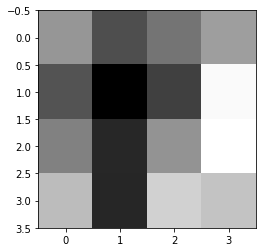

In [60]:
generated_latents = reverse_diffusion(unet, 8, 20)
plt.imshow(generated_latents[2].numpy().reshape(4, 4), cmap='gray')

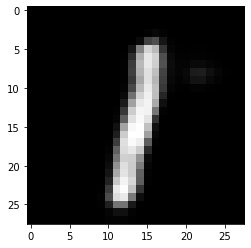

In [63]:
generated_latents = reverse_diffusion(unet, 2, 20)
generated_images = vae.decode(generated_latents)
plt.imshow(generated_images[0].numpy().reshape(28, 28), cmap='gray')

In [67]:
unet.save('../latent_diffusion_unet2')

INFO:tensorflow:Assets written to: ../latent_diffusion_unet2\assets


INFO:tensorflow:Assets written to: ../latent_diffusion_unet2\assets
